In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

import pickle

In [2]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

c:\Users\Revalda Putawara\.conda\envs\bnntest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda")

In [4]:
class BayesianCNNSingleFC(PyroModule):
    def __init__(self, num_classes):
        super().__init__()

        prior_mu = 0.
        #prior_sigma = 0.1 #accuracy 13.203704% 2 epochs
        #prior_sigma = 1. #accuracy 31% 2 epochs
        prior_sigma = torch.tensor(10., device=device) #accuracy 45% 10 epochs
        #prior_sigma = 100 #accuracy 21% 10 epochs

        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(prior_mu, prior_sigma).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(prior_mu, prior_sigma).expand([32]).to_event(1))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2) #initially padding=1 kernel_size=3, without stride
        self.conv2.weight = PyroSample(dist.Normal(prior_mu, prior_sigma).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(prior_mu, prior_sigma).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = PyroModule[nn.Linear](64 * 16 * 16, num_classes)
        self.fc1.weight = PyroSample(dist.Normal(prior_mu, prior_sigma).expand([num_classes, 64 * 16 * 16]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(prior_mu, prior_sigma).expand([num_classes]).to_event(1))

    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        logits = self.fc1(x)
        
        # THIS IS THE MISSING PIECE: Define the likelihood
        if y is not None:
            with pyro.plate("data", x.shape[0]):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        
        return logits

In [5]:
def load_data(batch_size=54): 
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    # Use fixed random seed for reproducible splits
    torch.manual_seed(42)
    #train_size = int(0.8 * len(dataset))
    #test_size = len(dataset) - train_size
    #train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, test_loader

In [6]:
def load_data(batch_size=54):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    torch.manual_seed(42)
    
    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [7]:
num_classes = 10
bayesian_model = BayesianCNNSingleFC(num_classes=num_classes).to(device)

In [8]:
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam

In [9]:
guide = AutoDiagonalNormal(bayesian_model)

# 2. Optimizer and SVI - increase learning rate for better convergence
optimizer = Adam({"lr": 1e-3})  # Increased from 1e-4 to 1e-3
svi = pyro.infer.SVI(model=bayesian_model,
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

In [10]:
from tqdm import tqdm

In [11]:
def train_svi(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    #guide.to(device)
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")


In [12]:
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

train_loader, test_loader = load_data(batch_size=54)
train_svi(bayesian_model, guide, svi, train_loader, num_epochs=10)

Epoch 1/10: 100%|██████████| 400/400 [00:56<00:00,  7.07it/s]


Epoch 1 - ELBO Loss: 14810549.6158


Epoch 2/10: 100%|██████████| 400/400 [00:17<00:00, 22.58it/s]


Epoch 2 - ELBO Loss: 8030741.2743


Epoch 3/10: 100%|██████████| 400/400 [00:13<00:00, 29.32it/s]


Epoch 3 - ELBO Loss: 6241734.9250


Epoch 4/10: 100%|██████████| 400/400 [00:13<00:00, 29.46it/s]


Epoch 4 - ELBO Loss: 5222115.9065


Epoch 5/10: 100%|██████████| 400/400 [00:13<00:00, 29.31it/s]


Epoch 5 - ELBO Loss: 4541996.4318


Epoch 6/10: 100%|██████████| 400/400 [00:13<00:00, 29.28it/s]


Epoch 6 - ELBO Loss: 4003914.5466


Epoch 7/10: 100%|██████████| 400/400 [00:13<00:00, 29.34it/s]


Epoch 7 - ELBO Loss: 3589323.7173


Epoch 8/10: 100%|██████████| 400/400 [00:13<00:00, 29.72it/s]


Epoch 8 - ELBO Loss: 3243001.6419


Epoch 9/10: 100%|██████████| 400/400 [00:14<00:00, 28.40it/s]


Epoch 9 - ELBO Loss: 2984078.5924


Epoch 10/10: 100%|██████████| 400/400 [00:13<00:00, 29.91it/s]

Epoch 10 - ELBO Loss: 2753264.9328


In [13]:
# print confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix


def predict_data(model, test_loader, num_samples=10):
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            logits_mc = torch.zeros(num_samples, images.size(0), model.fc1.out_features).to(device)

            for i in range(num_samples):
                guide_trace = pyro.poutine.trace(guide).get_trace()
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                logits = replayed_model(images)
                logits_mc[i] = logits

            avg_logits = logits_mc.mean(dim=0)
            predictions = torch.argmax(avg_logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    return all_labels, all_predictions

In [14]:
all_labels, all_predictions = predict_data(bayesian_model, test_loader, num_samples=10)

Evaluating: 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


In [15]:
cm = confusion_matrix(all_labels, all_predictions)

In [16]:
#print accuracy from confusion matrix
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy from confusion matrix: {accuracy * 100:.6f}%")

Accuracy from confusion matrix: 60.166667%


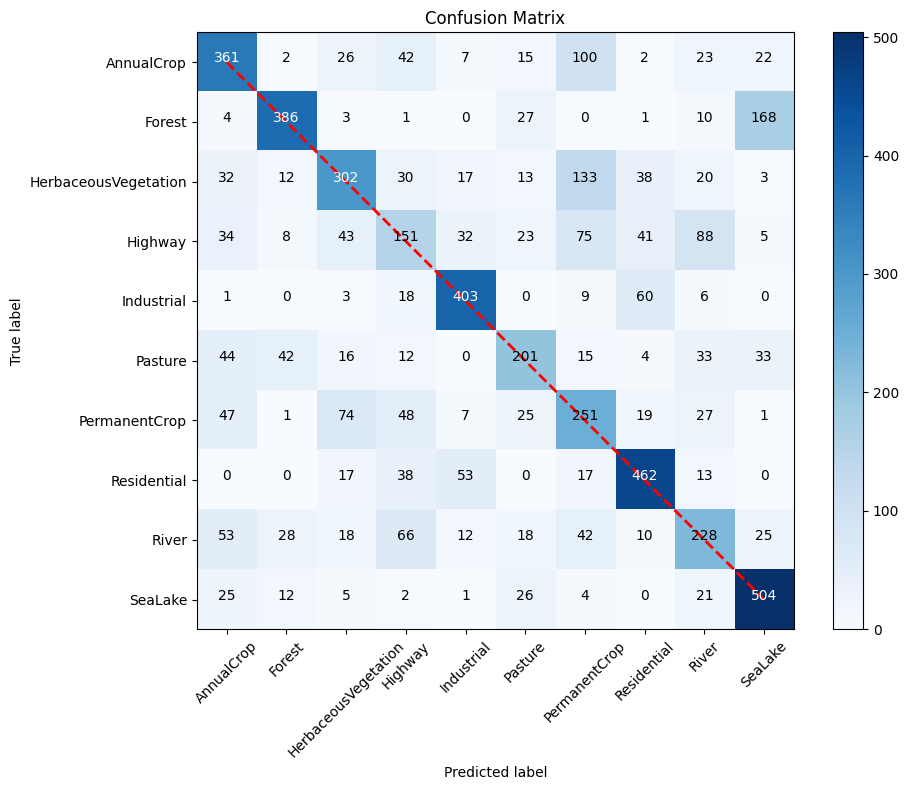

In [17]:
# plot the confusion matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    # make a mark to the diagonal
    plt.plot([0, cm.shape[1]-1], [0, cm.shape[0]-1], color='red', linestyle='--', linewidth=2)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot the confusion matrix
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
plot_confusion_matrix(cm, class_names)

In [18]:
# save the model
model_path = 'results_eurosat/bayesian_cnn_model_std10_10_epoch.pth'
torch.save(bayesian_model.state_dict(), model_path)

# save the guide
guide_path = 'results_eurosat/bayesian_cnn_guide_std10_10_epoch_guide.pth'
torch.save(guide.state_dict(), guide_path)

# save the pyro parameter store
pyro_param_store_path = 'results_eurosat/pyro_param_store_std10_10_epoch.pkl'
pyro.get_param_store().save(pyro_param_store_path)

In [ ]:
# load model, guide, and pyro parameter store
def load_model_and_guide(model_path, guide_path, pyro_param_store_path):
    model = BayesianCNNSingleFC(num_classes=10).to(device)
    model.load_state_dict(torch.load(model_path))
    
    guide = AutoDiagonalNormal(model)
    guide.load_state_dict(torch.load(guide_path))
    
    pyro.get_param_store().load(pyro_param_store_path)
    
    return model, guide

Feature TODO:
1. Record loss after each epoch
2. Send result to GPU